# FD PARAMETER COMPARISON

In [1]:
import os
os.chdir(os.path.pardir)

In [2]:
from utilities import *

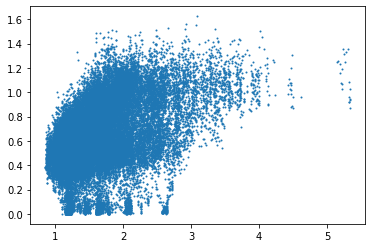

In [3]:
data_path = "../data/dataset_corridor_85"
fd_data, fd_targets = read_dataset(data_path, fd_training=True)
plt.scatter(fd_data, fd_targets, s=1)  # original data
plt.show()

### FIT FD MODEL ON OBSERVATIONS

In [ ]:
indexes = np.arange(len(fd_data))
indexes = np.random.choice(indexes, size=10000, replace=True)
fd_data = fd_data[indexes]
fd_targets = fd_targets[indexes]

plt.scatter(fd_data, fd_targets, s=1)  # original data
plt.show()

# to stop the computation when model is at its cap
callback = EarlyStopping(monitor='loss', patience=10)  # default on val_loss

# train the FD model
model = FD_Network()
model.compile(optimizer='adam', loss='mse', run_eagerly=True)
model.fit(x=fd_data, y=fd_targets, epochs=50, verbose=2, callbacks=[callback])

# generate the FD speeds with prediction
mean_spacings = fd_data
fd_speeds = model.predict(x=mean_spacings)
model.mse = np.mean((fd_speeds-fd_targets)**2)


# plot the FD prediction over the observations
plt.scatter(fd_data, fd_targets, s=1)  # original data
plt.scatter(mean_spacings, fd_speeds, c='orange', s=1)  # fd model data
plt.xlabel("Mean spacing")
plt.ylabel("Speed")
plt.title("FD-Observations")
plt.show()

### VISUALIZE PARAMETERS FITTING EFFECT BATCH AFTER BATCH (FIT ON OBSERVATIONS)

In [ ]:
fd1_params['t'] = np.array([model.FD_model_parameters['t'][i] for i in range(len(model.FD_model_parameters['t']))]).flatten()
fd1_params['l'] = np.array([model.FD_model_parameters['l'][i] for i in range(len(model.FD_model_parameters['l']))]).flatten()
fd1_params['v0'] = np.array([model.FD_model_parameters['v0'][i] for i in range(len(model.FD_model_parameters['v0']))]).flatten()

plt.scatter(range(fd1_params['t'].shape[0]), fd1_params['t'], s=1, label='t')
plt.scatter(range(fd1_params['l'].shape[0]), fd1_params['l'], s=1, label='l')
plt.scatter(range(fd1_params['v0'].shape[0]), fd1_params['v0'], s=1, label='v0')
plt.legend()
plt.show()

### CREATE PREDICTIONS  AND FIT AN FD MODEL ON THEM

In [ ]:
fd_data, fd_targets = read_dataset(data_path, fd_training=True)
nn_data, nn_targets = read_dataset(data_path, fd_training=False)


# to stop the computation when model is at its cap
callback = EarlyStopping(monitor='loss', patience=10)  # default on val_loss

hidden_dims = (3,)

# train the speed predictor neural network
print("Training the NN model..")
nn = create_nn(hidden_dims, dropout=-1)
nn.compile(optimizer='adam', loss='mse')
hist = nn.fit(x=nn_data, y=nn_targets, epochs=1000, callbacks=[callback], verbose=1)
loss_nn = hist.history['loss']

# create the speed for FD to learn
nn_speeds = nn.predict(x=nn_data)

# train the FD model
print("Training the FD model..")
fd_data = fd_data[indexes]
nn_speeds = nn_speeds[indexes]
model2 = FD_Network()
model2.compile(optimizer='adam', loss='mse', run_eagerly=True)
hist = model2.fit(x=fd_data, y=nn_speeds, epochs=50, callbacks=[callback], verbose=1)
loss_fd = hist.history['loss']

# training plots
if training_plots:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    # FD
    ax[0].plot(loss_fd)
    ax[0].set_title("FD training")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("MSE")
    # NN
    ax[1].plot(loss_nn, c='red')
    ax[1].set_title("NN training")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("MSE")
    fig.show()

# plot
mean_spacings = fd_data
fd_speeds = model2.predict(x=mean_spacings)
fig, ax = plt.subplots(1, 1)
ax.plot(mean_spacings, fd_speeds, c='orange')
ax.scatter(nn_data[:, 0], nn_speeds, s=1, c='red')
ax.set_xlabel("Mean spacing")
ax.set_ylabel("Speed")
# fig.suptitle("")
plt.show()

### VISUALIZE PARAMETERS FITTING EFFECT BATCH AFTER BATCH (FIT ON PREDICTIONS)

In [ ]:
fd2_params = model2.FD_model_parameters
fd2_params['t'] = np.array([model2.FD_model_parameters['t'][i] for i in range(len(model2.FD_model_parameters['t']))]).flatten()
fd2_params['l'] = np.array([model2.FD_model_parameters['l'][i] for i in range(len(model2.FD_model_parameters['l']))]).flatten()
fd2_params['v0'] = np.array([model2.FD_model_parameters['v0'][i] for i in range(len(model2.FD_model_parameters['v0']))]).flatten()

plt.scatter(range(fd2_params['t'].shape[0]), fd2_params['t'], s=1, label='t')
plt.scatter(range(fd2_params['l'].shape[0]), fd2_params['l'], s=1, label='l')
plt.scatter(range(fd2_params['v0'].shape[0]), fd2_params['v0'], s=1, label='v0')
plt.legend()
plt.show()


### COMPARE RESULTS

In [ ]:
fd1_t = round(np.mean(fd1_params['t'][1000:]),3)
fd1_l = round(np.mean(fd1_params['l'][1000:]),3)
fd1_v0 = round(np.mean(fd1_params['v0'][1000:]),3)
fd2_t = round(np.mean(fd2_params['t'][1000:]),3)
fd2_l = round(np.mean(fd2_params['l'][1000:]),3)
fd2_v0 = round(np.mean(fd2_params['v0'][1000:]),3)

In [ ]:
fd1_t, fd2_t

In [ ]:
fd1_l, fd2_l

In [ ]:
fd1_v0, fd2_v0